In [1]:
#Imports
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage, misc

# SK-Learn
from skimage.feature import hog
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Image Directory
train_dir = 'Data/train/'
test_dir = 'Data/test/'

In [2]:
#Count the number of images in the different categories in training and test set
row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3952      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


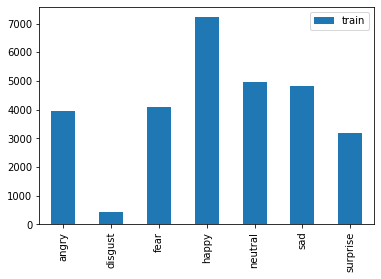

In [3]:
#Plot number of images in training set
train_count.transpose().plot(kind='bar')

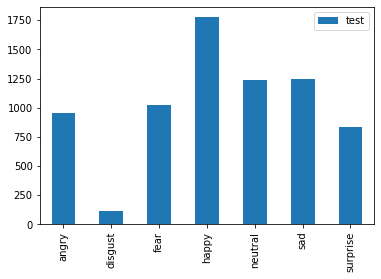

In [4]:
#Plot number of images in test set 
test_count.transpose().plot(kind='bar')

In [5]:
#Import pictures
def load_images_from_folder(folder):
    #create an integer value for each of 7 categories
    class_names = os.listdir(folder) # Get names of classes
    class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

    images, labels = [], []
    for expression in os.listdir(folder):
        path = folder + expression
        label_id = class_name2id[expression]
      
        for filename in os.listdir(path):
            img = cv2.imread(path + '/' +filename)

            if img is not None:
                images.append(img)
                labels.append(label_id)
    return images, labels


In [6]:
class_names = os.listdir(train_dir) # Get names of classes
class_name2id = { label: index for index, label in enumerate(class_names) } # Map class names to integer labels

print(class_names)
#print(class_name2id['angry'])

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


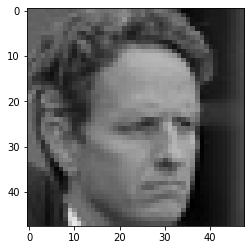

In [7]:
training, labels_training = load_images_from_folder(train_dir)
testing, labels_testing = load_images_from_folder(test_dir)

#Display first image in training data
img = training[0]
imgplot = plt.imshow(img)
plt.show()

## Feature Extraction

In [8]:
#Caculate HoG for every image in data

hog_features_training = np.asarray([hog(image_training, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_training in training])
hog_features_test = np.asarray([hog(image_test, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2,2)) for image_test in testing])

#print shape
print(hog_features_training.shape)
print(hog_features_test.shape)

(28666, 900)
(7178, 900)


In [11]:
#Split up into training and test 
X_trn_hog = hog_features_training
Y_trn = labels_training 

X_test_hog = hog_features_test
Y_test = labels_testing 

## SVM Classifiers

HoG Accuracy: 0.4453886876567289


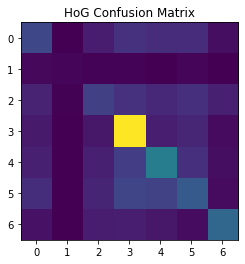

In [13]:
#Linear SVM
# create SVM models
svm_hog = svm.SVC(kernel='linear', gamma='scale')

# train SVM models
svm_hog.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
hog_predictions = svm_hog.predict(X_test_hog)
print('HoG Accuracy: {}'.format(accuracy_score(Y_test, hog_predictions))) 
plt.subplot(111), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('HoG Confusion Matrix')
plt.show()

In [9]:
#Non-Linear SVMS - poly and rbf kernel
#THIS TAKES TO LONG
# create SVM models
svm_poly = svm.SVC(kernel='poly', gamma='scale')
svm_rbf = svm.SVC(kernel='rbf', gamma='scale')

# train SVM models
svm_poly.fit(X_trn_hog, Y_trn)
svm_rbf.fit(X_trn_hog, Y_trn)

# evaluate SVM models with the confusion matrix and with accuracy
poly_predictions = svm_poly.predict(X_test_hog)
rbf_predictions = svm_rbf.predict(X_test_hog)
print('Polynomial Accuracy: {}'.format(accuracy_score(Y_test, poly_predictions)))
print('Radial Basis Function Accuracy: {}'.format(accuracy_score(Y_test, rbf_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_test, poly_predictions)), plt.title('Polynomial Confusion Matrix')
plt.subplot(122), plt.imshow(confusion_matrix(Y_test, hog_predictions)), plt.title('RBF Confusion Matrix')
plt.show()

KeyboardInterrupt: 

## Random Forest Classifiers

In [9]:
def randomForest(nbr_estimators_list):
    for nbr_estimator in nbr_estimators_list:
        # create random forest classifier
        rf = RandomForestClassifier(n_estimators=nbr_estimator, criterion='entropy')

        # train classifier
        rf.fit(X_trn_hog, Y_trn)

        # evaluate classifier performance
        rf_predictions = rf.predict(X_test_hog)
        print('Random Forest Accuracy: {}'.format(accuracy_score(Y_test, rf_predictions)))
        plt.imshow(confusion_matrix(Y_test, rf_predictions)), plt.title('Random Forest Confusion Matrix')
        plt.show()

Random Forest Accuracy: 0.4566731680133742


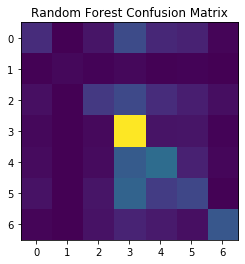

Random Forest Accuracy: 0.4717191418222346


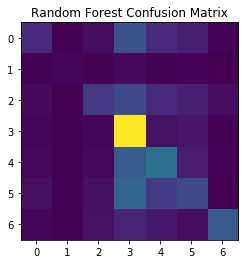

Random Forest Accuracy: 0.475619949846754


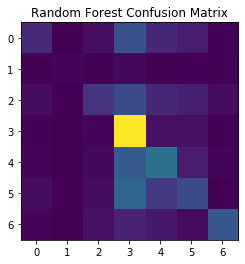

Random Forest Accuracy: 0.4767344664251881


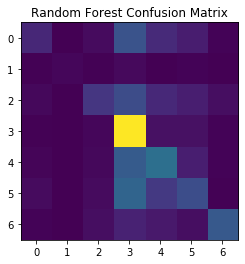

Random Forest Accuracy: 0.4763165227082753


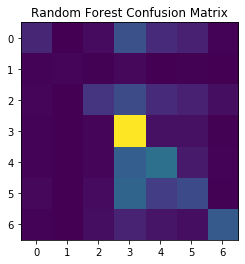

Random Forest Accuracy: 0.4793814432989691


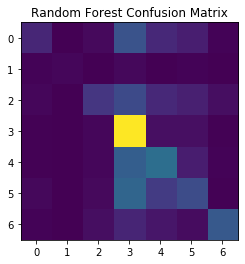

In [12]:
nbr_estimators_list = [100, 200, 300, 400, 500, 1000]
randomForest(nbr_estimators_list)

## Comparison of Classifiers

SVM RBF Training Set Accuracy: 0.5087211330496058
Random Forest 1000-tree Training Set Accuracy: 0.9985697341798646


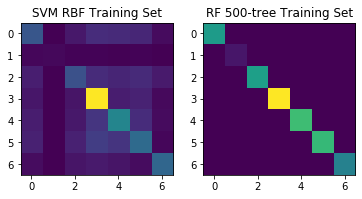

[[-2475     4   352   704   656   593   166]
 [   98  -327    63    52    40    60    14]
 [  456     8 -2727   669   559   649   386]
 [  336     3   308 -1740   432   522   139]
 [  429     4   354   841 -2473   691   154]
 [  505     7   500   988   825 -2931   106]
 [  186     0   310   393   302   178 -1369]]


In [15]:
#Performance Analysis

# predictions on training set for both classifiers
hog_predictions = svm_hog.predict(X_trn_hog)

# create random forest classifier
rf = RandomForestClassifier(n_estimators=500, criterion='entropy')

# train classifier
rf.fit(X_trn_hog, Y_trn)

# evaluate classifier performance
rf_predictions = rf.predict(X_trn_hog)

print('SVM Linear Training Set Accuracy: {}'.format(accuracy_score(Y_trn, svm_linear)))
print('Random Forest 1000-tree Training Set Accuracy: {}'.format(accuracy_score(Y_trn, rf_predictions)))
plt.subplot(121), plt.imshow(confusion_matrix(Y_trn, svm_linear)), plt.title('SVM RBF Training Set')
plt.subplot(122), plt.imshow(confusion_matrix(Y_trn, rf_predictions)), plt.title('RF 500-tree Training Set')
plt.show()

# compare confusion matrices
print(np.subtract(confusion_matrix(Y_trn, svm_linear), confusion_matrix(Y_trn, rf_predictions)))


In [16]:
#Exploring different parameters of HoG
svm_linear_hogtest = svm.SVC(kernel='linear', gamma='scale')
rf500_hogtest = RandomForestClassifier(n_estimators=500, criterion='entropy')
variedHoGpredictions = np.empty((8, 2, 10000))   # saved in order of for loop

index = 0
for cellsize in [6, 8, 10]:
    for blocksize in [1, 2, 3]:
        for orientationbins in [8, 9, 10]:
            hogIterFeatures = np.asarray([hog(image, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for image in training])
            testHogIterFeatures = np.asarray([hog(testImage, orientations=orientationbins, pixels_per_cell=(cellsize,cellsize), cells_per_block=(blocksize,blocksize)) for testImage in testing])
            
            svm_linear_hogtest.fit(hogIterFeatures, Y_trn)
            rf500_hogtest.fit(hogIterFeatures, Y_trn)
            
            svm_linear_hogtest_predictions = svm_linear_hogtest.predict(testHogIterFeatures)
            rf500_hogtest_predictions = rf500_hogtest.predict(testHogIterFeatures)
            variedHoGpredictions[index][0] = svm_linear_hogtest_predictions
            variedHoGpredictions[index][1] = rf500_hogtest_predictions
            print('SVM-Linear Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, svm_linear_hogtest_predictions)))
            print('RF 500-tree Accuracy with cellsize={}, blocksize={}, orientationbins={}: {}'.format(cellsize, blocksize, orientationbins, accuracy_score(Y_test, rf500_hogtest_predictions)))
            plt.figure(figsize=(8, 4))
            plt.subplot(121), plt.imshow(confusion_matrix(Y_test, svm_rbf_hogtest_predictions)), plt.title('SVM-Linear ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.subplot(122), plt.imshow(confusion_matrix(Y_test, rf1000_hogtest_predictions)), plt.title('RF 500-tree ({}, {}, {})'.format(cellsize, blocksize, orientationbins))
            plt.show()

KeyboardInterrupt: 